<a href="https://colab.research.google.com/github/astrophysicsvivien/GWPEtutorial/blob/main/GWPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gravitational-wave Inference

This notebook is based in part on the [2018 open data workshop](https://github.com/gw-odw/odw-2018).

## Bayes' Theorem:

We will construct a posterior function for use in Bayesian inference of source properties. The posterior density function describes the distribution of probability (density) for all of our model parameters after observations:

$$
p(\vec{\lambda}|s,M) = \frac{p(\vec{\lambda}|M)p(s|\vec{\lambda},M)}{p(s|M)},
$$

where $\vec{\lambda}$ contains all of the parameters of  the model $M$ that we don't know, and $s=\{s_1, s_2, \ldots, s_{\mathrm{N}_f}\}$ are our data, in this case the strain measurements across $\mathrm{N}_f$ discrete frequency bins.

$p(\vec{\lambda})$ is the *prior*, describing our knowledge of the parameters before recording any data, e.g., we expect compact binaries' orientations to be isotropically distributed.  $p(s|\vec{\lambda})$ is the *likelihood*, which is the probability of observing the data that we've observed *if* all of the unknown parameters were to have values $\vec{\lambda}$.  Finally, $p(s)$ is the *evidence*, which for simple parameter estimation is a normalization that we can ignore, but becomes useful for model comparisons.

To be successful in our Bayesian endeavor, we need forward models to describe (probabilistically) our observed data, i.e., signal and noise processes.  From now on we'll be making strong assumptions about the content of the data, specifically that the data consist of stationary, Gaussian noise with a known power spectral density, and a compact binary signal as described by the `SEOBNRv4` model.

##  Getting the software environment setup

[PyCBC](https://pycbc.org/) is installable through pip, but also relies on portions of the LALSuite c-library. A bundled version of this suitable for use with PyCBC is also available on Mac / Linux through pip. These can be installed as follows within the notebook.

In [1]:
import sys
!{sys.executable} -m pip install -q pycbc ligo-common --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 266.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 243.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 190.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 188.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 119.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 173.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 117.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting require

And some useful imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Data

As a concrete example we will work with the data containing **GW150914**.  Since we know *a priori* that there isn't any signal content about 1 kHz, we'll downsample the data to 2048 Hz for faster processing.  We will use both Hanford and Livingston data.

In [3]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

In [4]:
merger = Merger("GW150914")
time_center = merger.time

data={} # an empty dictionary
ifos=['L1','H1'] # a list which we use as the dictionary keys
for ifo in ifos:
    data[ifo] = merger.strain(ifo)

In [5]:
# Remove the low frequency content and downsample the data to 2048Hz
for ifo in ['H1','L1']:
    data[ifo] = resample_to_delta_t(highpass(data[ifo], 15.0), 1.0/2048)
    data[ifo] = data[ifo].crop(2,2)

Taking a look at the data:

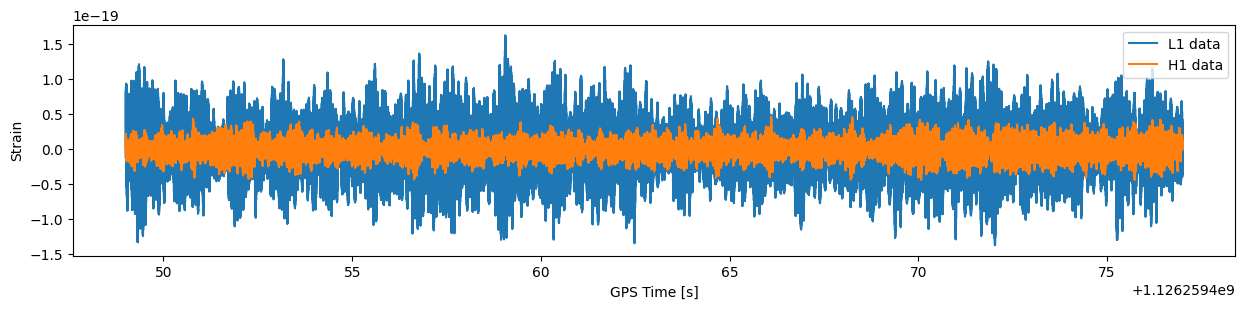

In [6]:
plt.figure(figsize=[15, 3])

for ifo in ifos:
    plt.plot(data[ifo].sample_times,data[ifo],label='{} data'.format(ifo))
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend();

## Likelihood

### Noise model

We know the time around **GW150914** to be well-behaved, and by that we mean stationary and Gaussian.  That means we can completely describe the (statistical) properties of the noise by the power spectral density, which we'll estimate using off-source data following the procedure from the previous tutorial.

In [7]:
psd={}
for ifo in data:
    # This estimates the PSD by sub-dividing the data into overlapping
    # 4s long segments. (See Welch's method)
    psd[ifo] = data[ifo].psd(4)
    # We can now crop the data to be the same 4 second length
    data[ifo] = data[ifo].time_slice(time_center-2,time_center+2)

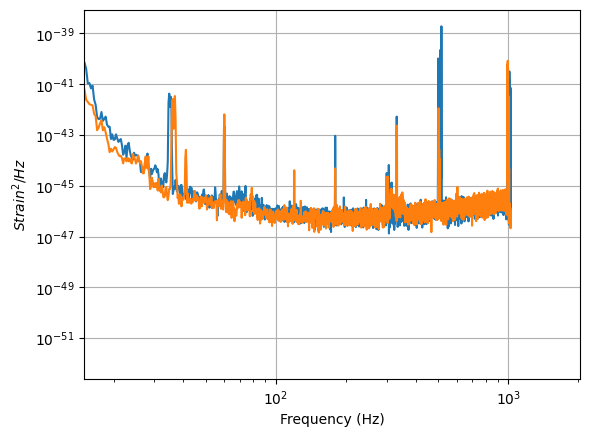

In [8]:
for ifo in ifos:
    plt.loglog(psd[ifo].sample_frequencies, psd[ifo])

plt.ylabel('$Strain^2 / Hz$')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.xlim(15, 2048)
plt.show()

That's it.  We're going to assume that our noise is exactly described by the PSD estimated above.  In other words, we're employing a 0-parameter noise model.

For production LVK analyses we make use of the [BayesLine](https://arxiv.org/abs/1410.3852) algorithm, which employs a parametric model for the PSD itself and allows us to work with only on-source data.

## Signal model

Here we are using the `SEOBNRv4` approximant, which describes the inspiral, merger, and ringdown phases of a binary black hole merger using a combination of analytical approximations and fits to numerical relativity simulations.

In [9]:
from pycbc.waveform import get_td_waveform

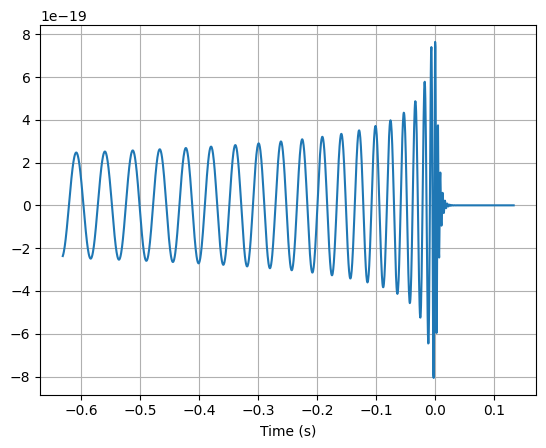

In [10]:
m1 = 38.9 # Solar masses
m2 = 31.6 # Solar masses

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m1,
                     mass2=m2,
                     delta_t=data['H1'].delta_t,
                     f_lower=20)

plt.plot(hp.sample_times, hp)
plt.grid()
plt.xlabel('Time (s)');

With two detectors we are potentially sensitive to more than a single polarization of gravitational waves.  We also have to account for the delay in the time of arrival of the signal based on where in the sky the source may be located.  This expands our parameters to be component mass (assuming an equal mass binary), right ascension, declination, luminosity distance, inclination, merger time, merger phase, and polarization angle.

For a give set of parameters $\vec{\lambda}$ we'll now have to generate the plus and cross polarizations of the GW emission (taking into account the inclination of the binary, and scaling to the proper distance), then combine these with each detector's antenna pattern (which depend on the location of the binary relative to the detector's orientation) to determine the detector response.  Finally, we have to shift the time of arrival of the signal to be consistent with the delay time expected based on the RA and dec of the binary.

In short, you can think of the process as generating the geocenter waveform then projecting it across the network.

Here we will use the `Detector` python object with which we can compute the antenna beam patterns $F_+$ and $F_{\times}$ for a a specific sky-position and polarisation angle:

In [11]:
from pycbc.detector import Detector

In [12]:
# Creating the detector objects:
det={}
for ifo in ifos:
    det[ifo]=Detector(ifo)

In [13]:
declination = 2.2
right_ascension =  -1.2
polarization = 0.0

fp={}
fc={}
for ifo in ifos:
    fp[ifo], fc[ifo] = det[ifo].antenna_pattern(right_ascension, declination, polarization, time_center)
    print("{}: fp={}, fc={}".format(ifo,fp[ifo], fc[ifo]))

L1: fp=0.42421991687926563, fc=0.5200300358947472
H1: fp=-0.15655913863934806, fc=-0.6483411723761439


With the antenna beam pattern functions we can then compute the gravitational-wave signal as seen by each detector:

In [14]:
ht={}
for ifo in ifos:
    ht[ifo] = fp[ifo] * hp + fc[ifo] * hc

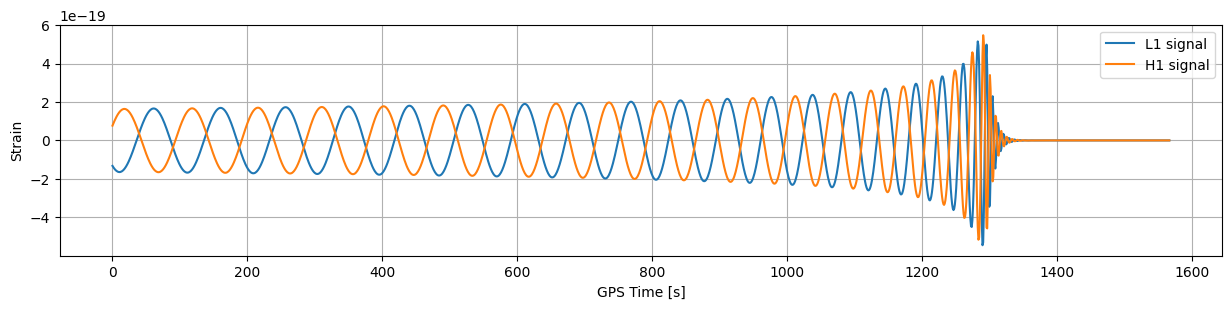

In [15]:
plt.figure(figsize=[15, 3])

for ifo in ifos:
    plt.plot(ht[ifo],label='{} signal'.format(ifo))
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.grid()
plt.legend();

For visualization it is still useful to look at the whitened data, where the data have been filtered to produce a flat PSD. We also remove the frequencies below 30Hz and above 300Hz:

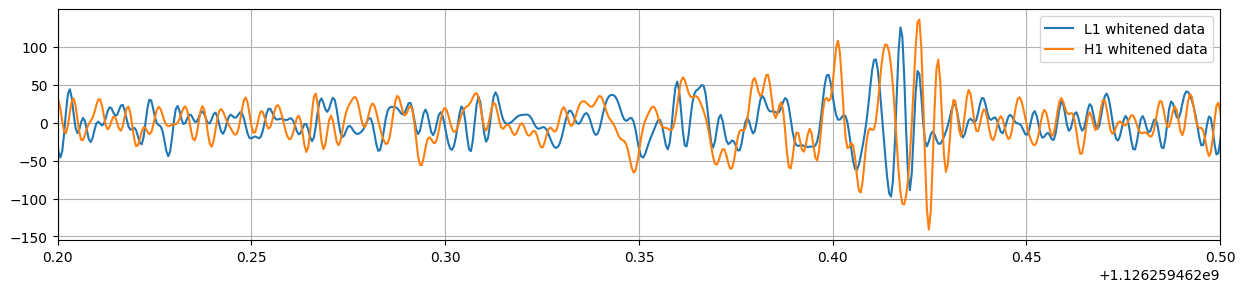

In [16]:
plt.figure(figsize=[15, 3])

white_data={}
for ifo in ifos:
    #white_data[ifo]=data[ifo].whiten(segment_duration=4, max_filter_duration=4).highpass_fir(30, 512).lowpass_fir(300, 512)
    white_data[ifo]=(data[ifo].to_frequencyseries() / psd[ifo]**0.5).to_timeseries()
    white_data[ifo]=white_data[ifo].highpass_fir(30, 512).lowpass_fir(300, 512)
    plt.plot(white_data[ifo].sample_times,white_data[ifo],label='{} whitened data'.format(ifo))
plt.xlim(time_center-.2, time_center+.1)
plt.grid()
plt.legend();

We also need to compute the time-delay between our refence time-at-geocenter and the time at which the gravitational-wave signal will hit the detectors:

In [17]:
time_delay=det['H1'].time_delay_from_earth_center(right_ascension, declination, time_center)

print("For the sky-position ra={},dec={}, at time={},".format(right_ascension,declination,time_center))
print("the time delay between Hanford and geocenter is {} seconds".format(time_delay))

For the sky-position ra=-1.2,dec=2.2, at time=1126259462.4,
the time delay between Hanford and geocenter is -0.012421147499456449 seconds


Let's make a light-weight wrapper for `get_td_waveform()` that will take parameter vector $\vec{\lambda}$ and generate a waveform for us with the same sampling rate and time window as our data. However, this time we need to project the "plus" and "cross" polarisations onto the detector arms.

In [18]:
def gen_template(param,
                 delta_t=data['H1'].delta_t, # Assuming all IFOs have the same dt !
                 duration=data['H1'].duration, # Assuming all IFOs have the same duration !
                 start_time=data['H1'].start_time,# Assuming all IFOs have the same start time !
                 f_lower=20.):

    m1, m2, distance, time, phase, right_ascension, declination, inclination, polarization = param

    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m1,
                             mass2=m2,
                             distance=distance,
                             inclination=inclination,
                             coa_phase=phase,
                             delta_t=delta_t,
                             f_lower=f_lower)

    # Resize the signal buffer
    hp.resize(int(duration/delta_t))
    hc.resize(int(duration/delta_t))

    ht={}
    template={}
    # compute the detectors responses and shift to the requested time
    for ifo in ifos:
        fp, fc = det[ifo].antenna_pattern(right_ascension, declination, polarization, time)
        ht[ifo] = fp * hp.copy() + fc * hc.copy()

        time_delay = det[ifo].time_delay_from_earth_center(right_ascension, declination, time)

        ht[ifo] = ht[ifo].cyclic_time_shift(ht[ifo].start_time + time - start_time + time_delay)
        ht[ifo].start_time=start_time

    return ht

(1126259461.9, 1126259462.5)

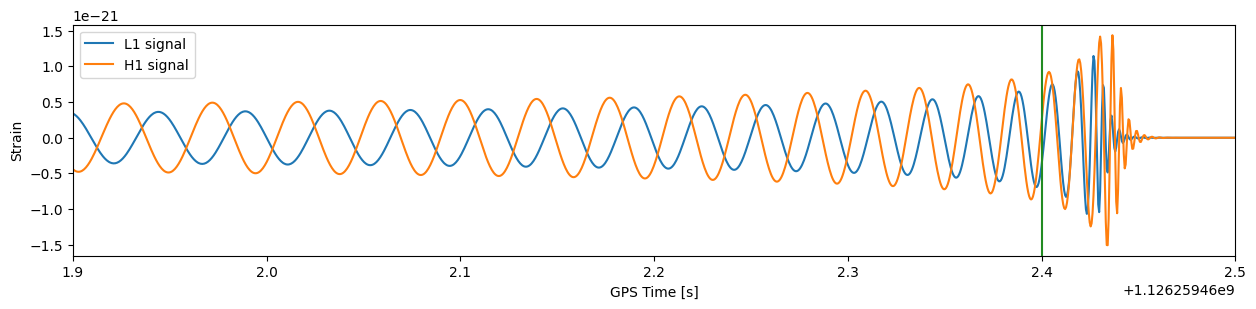

In [19]:
# Testing the gen_template() function:

param=[38.9,31.6,410,1126259462.42,0.0,2.2, -1.2, 0.1, 0.]
# m1, m2, distance, time, phase, right_ascension, declination, inclination, polarization = param

template=gen_template(param)
plt.figure(figsize=[15, 3])

for ifo in ifos:
    plt.plot(template[ifo].sample_times,template[ifo],label='{} signal'.format(ifo))
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend();
plt.axvline(time_center,c='forestgreen')
plt.xlim([time_center-0.5,time_center+0.1])

With the network waveform generator now defined, we can define our likelihood function, which is equivalent to the product of single-detector likelihood functions.

## Network Likelihood

To construct a likelihood function for the GW detector network (the two LIGO instruments in this case), we will make the very reasonable assumption that noise is independent between detectors.  This means that our network likelihood fuction is just the product of single-detector likelihood functions.

$$
\log \mathcal{L}_\mathrm{net} = \sum_{j \in \{\mathrm{H1}, \mathrm{L1}\}} \log \mathcal{L}_\mathrm{j}
$$



In [20]:
# FFT the data once, ahead of time
sf={}
for ifo in ifos:
    # In general you would need to use a window for the FFTs, e.g.:
    # window = signal.get_window(('tukey', 1./4.), len(data[ifo]))/np.absolute(win).mean()
    sf[ifo] = data[ifo].to_frequencyseries()

def loglikelihood(param, sf=sf, f_lower=20.0):

    logl=0.0
    template = gen_template(param, f_lower=f_lower)

    for ifo in ifos:
        # zero out the frequencies below f_lower
        kmin = int(f_lower / sf[ifo].delta_f)
        sf_hp = sf[ifo][kmin:]
        psd_hp = psd[ifo][kmin:]

        hf = template[ifo].to_frequencyseries()
        hf_hp = hf[kmin:]

        h_dot_h  = 4 * np.real((hf_hp * np.conjugate(hf_hp) / psd_hp).sum() * hf_hp.delta_f)
        h_dot_s  = 4 * np.real((sf_hp * np.conjugate(hf_hp) / psd_hp).sum() * sf_hp.delta_f)

        logl += h_dot_s - h_dot_h/2

    return logl

Now let's pick some particular values for the model parameters that we know to be in the right ballpark and generate a model signal.  We'll then whiten it and compare it to the data, and calculate the likelihood.

-1336.5834660665028


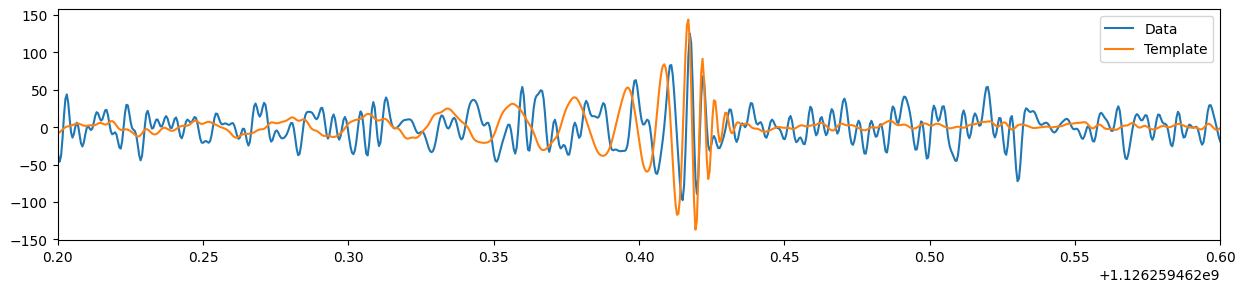

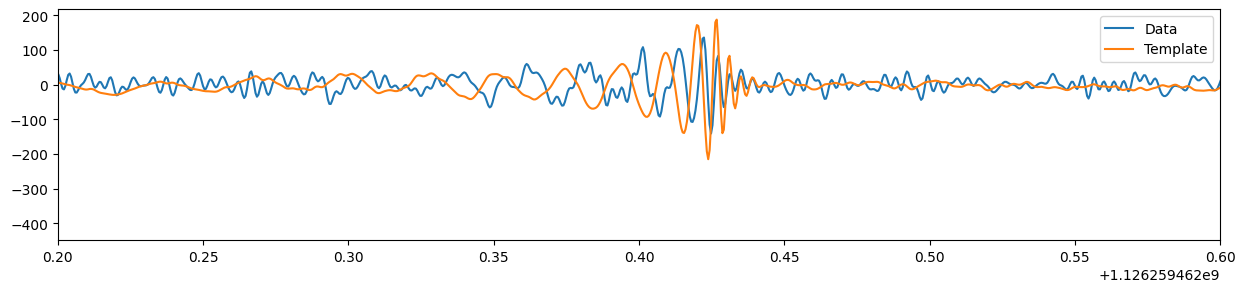

In [21]:
# m1, m2, distance, time, phase, right_ascension, declination, inclination, polarization
param0 = [38.9,31.6,410,1126259462.41,0.0,2.2, -1.2, 0.1, 0.]

template0 = gen_template(param0)
for ifo in ifos:
    white_template = (template0[ifo].to_frequencyseries() / psd[ifo]**0.5).to_timeseries()

    plt.figure(figsize=[15, 3])
    plt.plot(white_data[ifo].sample_times, white_data[ifo], label="Data")
    plt.plot(white_template.sample_times, white_template, label="Template")

    plt.xlim(time_center-.2, time_center+.2)
    plt.legend();
print(loglikelihood(param0))

Now let's maximize the likelihood to find the best-fit signal.  We'll use the `minimize()` function provided by scipy using the Powell method, since it's pretty good at dealing with non-smooth functions.  We'll also define a callback function to print likelihood values and plot the model as it works.

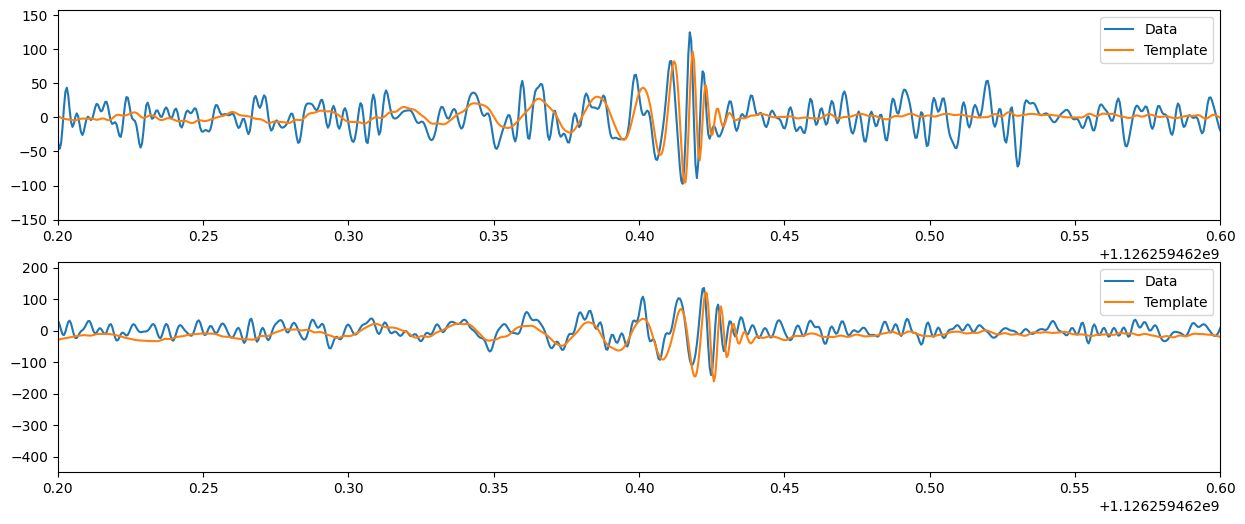

Steps	log(likelihood)
8	325.214


In [22]:
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, axs = plt.subplots(2, 1, figsize=[15, 6])
Neval = 1

lines = {}
for ax, ifo in zip(axs, ifos):
    white_template = (template0[ifo].to_frequencyseries() / psd[ifo]**0.5).to_timeseries()

    ax.plot(white_data[ifo].sample_times, white_data[ifo], label="Data")
    lines[ifo], = ax.plot(white_template.sample_times, white_template, label="Template")

    ax.set_xlim(time_center-.2, time_center+.2)
    ax.legend()

def callback(param_i):
    global Neval
    global line
    global fig

    template = gen_template(param_i)
    for ifo in ifos:
        white_template = (template[ifo].to_frequencyseries() / psd[ifo]**0.5).to_timeseries()
        lines[ifo].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, loglikelihood(param_i)))

    Neval += 1

res = minimize(lambda param: -loglikelihood(param), param0, callback=callback, method='powell')
plt.close()

We've now got our best-fit waveform, and it matches the data (although the minimizing algorithm does fail sometimes). This notebook only uses the `minimize()` routine for brevity, but you should try your favourite sampler to actually get the error bars.

In [23]:
best_fit = res.x
best_fit_template = gen_template(best_fit)

Now let's subtract it from the data and see how consistent the residuals are with noise. We are using here the [Q-transform](https://en.wikipedia.org/wiki/Constant-Q_transform) to produce a high-resolution time-frequency map of the data:

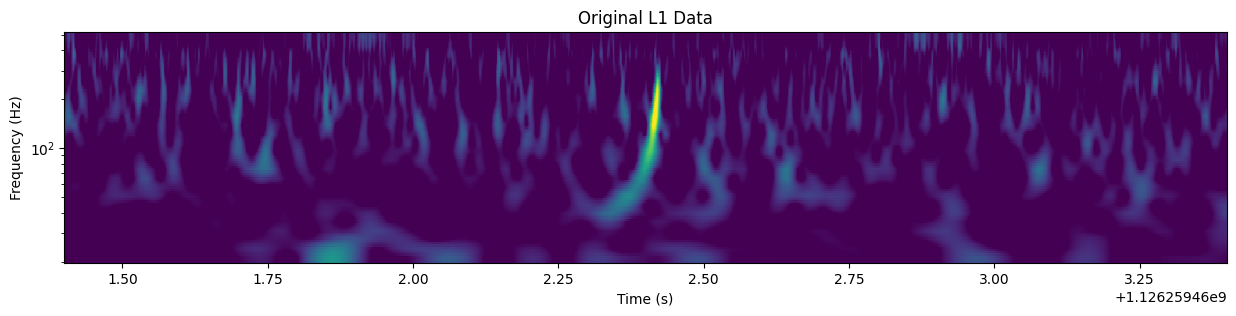

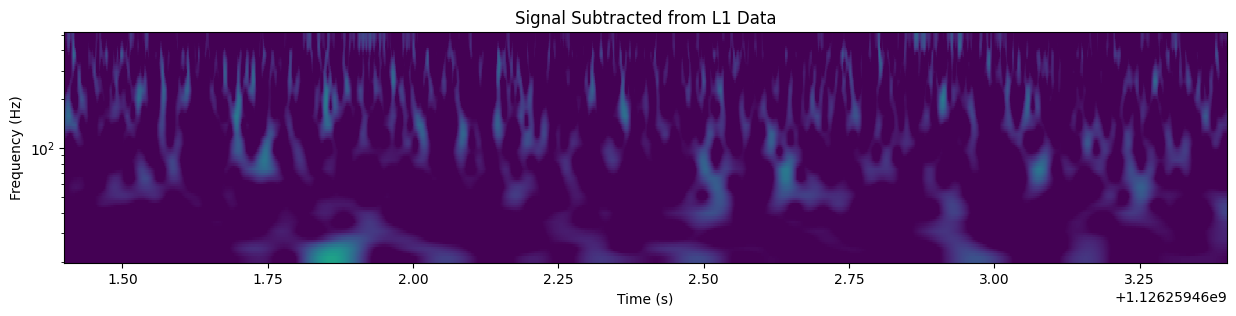

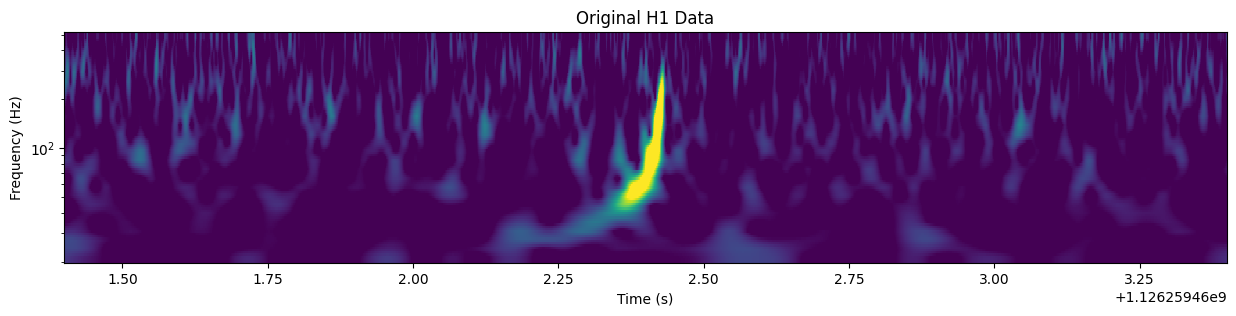

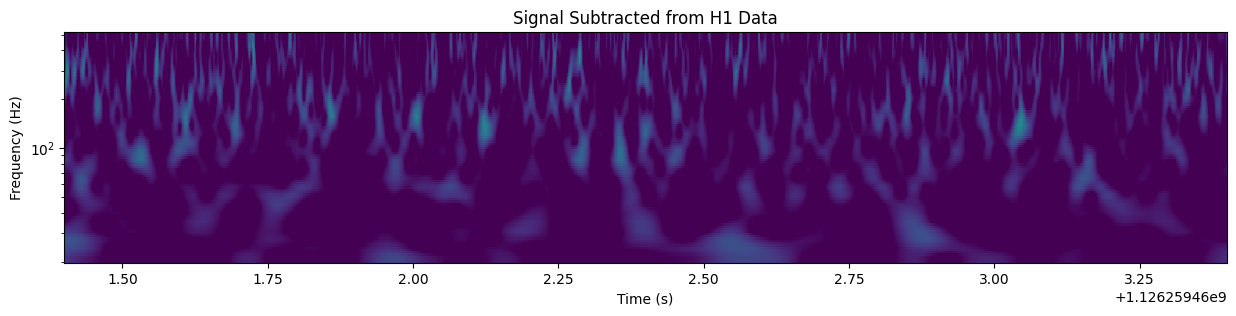

In [24]:
for ifo in ifos:
    subtracted = data[ifo] - best_fit_template[ifo]

    # Plot the original data and the subtracted signal data
    for d, title in [(data[ifo], 'Original {} Data'.format(ifo)),
                     (subtracted, 'Signal Subtracted from {} Data'.format(ifo))]:

        #qspecgram=d.whiten(asd=np.sqrt(psd[ifo])).q_transform(outseg=(time_center - 1, time_center + 1),
        #                                             frange=(20, 512))
        t, f, p = (d.to_frequencyseries() / psd[ifo]**0.5).to_timeseries().qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))

        plt.figure(figsize=[15, 3])
        plt.title(title)
        plt.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
        plt.yscale('log')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.xlim(merger.time - 1, merger.time + 1)
        plt.show()

# Prior

So far we've focused on the likelihood, but equally important to Bayesian inference is our prior, the knowledge of the distribution of model parameters that we have *before* taking any measuments.

If we were to sample the likelihood function defined above without specifying any priors, we are implicitly adopting uniform priors for the parameters of the model.  In other words, if we were to sample the same likelihood in a different parameterization, we would implicitly be using a *different* prior for our analysis.

While uniform priors for some parameters (e.g., merger time, merger phase, etc.) are justified, the fact that we expect sources to be distributed uniformly in the local universe (to 1st order) needs to be included in our prior, i.e.,

$$
p(\alpha, \delta) \propto \cos(\delta),
$$

where $\alpha \in [0, 2\pi]$ is the right ascenscion and $\delta \in [-\pi/2, \pi/2]$ the declination of the source, and

$$
p(D, \iota) \propto D^2\sin(\iota)
$$

where $D$ is the luminosity distance to the source, and $\iota$ is the inclination angle of the binary.

In [25]:
def logprior(param):
    logp = 0

    m1, m2, distance, time, phase, ra, dec, inclination, polarization= param

    for angle in [ra, phase, polarization]:
        if angle < 0 or angle > 2*np.pi:
            return -np.inf
    if distance < 0:
        return -np.inf
    if inclination < 0 or inclination > np.pi:
        return -np.inf
    if dec < -np.pi/2 or dec > np.pi/2:
        return -np.inf

    logp += np.log(np.cos(dec))
    logp += 2*np.log(distance)
    logp += np.log(np.sin(inclination))
    return logp

# Posterior

With network likelihood and prior defined we can now take their product to get the posterior.

In [26]:
def logposterior(param):
    logpost = logprior(param)
    if np.isfinite(logpost):
        logpost += loglikelihood(param)
    return logpost

In [27]:
logposterior(param0)

-1327.870527345816

We can now maximize the posterior to determine the *maximum a posteriori* (MAP) parameters.  

Where the maximum likelihood point was the "best fit" in the sense that it found the parameters that produced a model most consistent with the data, the MAP is more of a "best guess" in that it balances fitting the data with being consistent with prior expectations for source parameters.

However, as the posterior is a density, the MAP **does** depend on the parametrisation we chose.

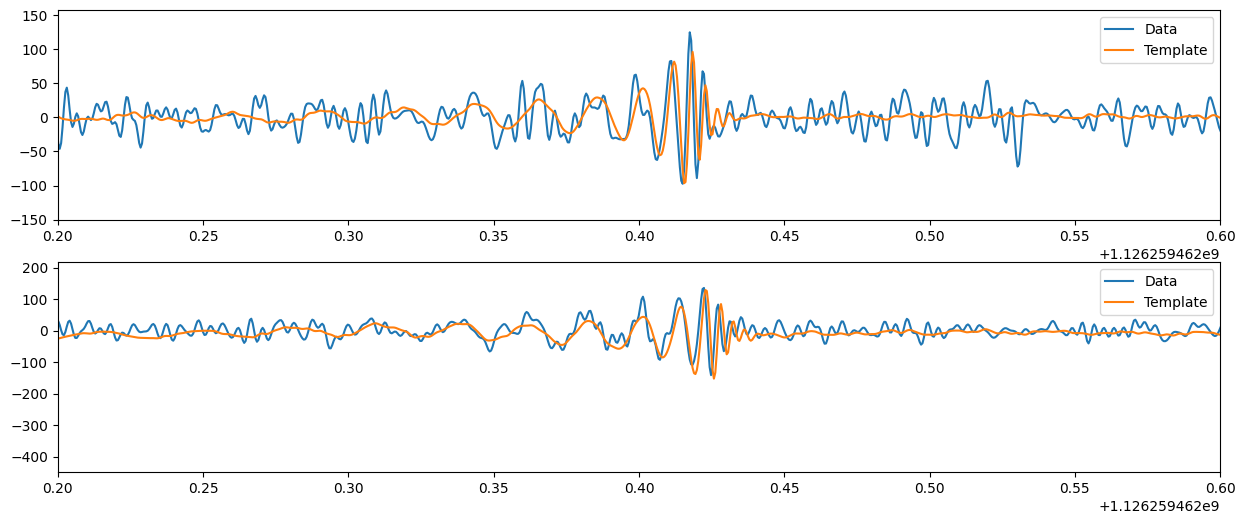

Steps	log(posterior)
12	338.596


In [28]:
fig, axs = plt.subplots(2, 1, figsize=[15, 6])
Neval = 1

lines = {}
for ax, ifo in zip(axs, ifos):
    white_template = (template0[ifo].to_frequencyseries() / psd[ifo]**0.5).to_timeseries()

    ax.plot(white_data[ifo].sample_times, white_data[ifo], label="Data")
    lines[ifo], = ax.plot(white_template.sample_times, white_template, label="Template")

    ax.set_xlim(time_center-.2, time_center+.2)
    ax.legend()

def callback(param_i):
    global Neval
    global line
    global fig

    template = gen_template(param_i)
    for ifo in ifos:
        white_template = (template[ifo].to_frequencyseries() / psd[ifo]**0.5).to_timeseries()
        lines[ifo].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(posterior)")
    print('{}\t{:.3f}'.format(Neval, logposterior(param_i)))

    Neval += 1

res = minimize(lambda param: -logposterior(param), param0, callback=callback, method='powell')
plt.close()

In [29]:
best_guess = res.x
print(best_guess)

[ 3.98855369e+01  3.16058529e+01  5.15413319e+02  1.12625946e+09
  2.19155476e-03  2.10383001e+00 -1.15646130e+00  4.83731451e-01
  1.73099369e-03]


We can easily take a look at some _slices_ in the parameter space, for instance at the `mass1` slice with all other parameters set the `best_guess` parameters:

Text(0.5, 0, 'Primary mass (solar mass)')

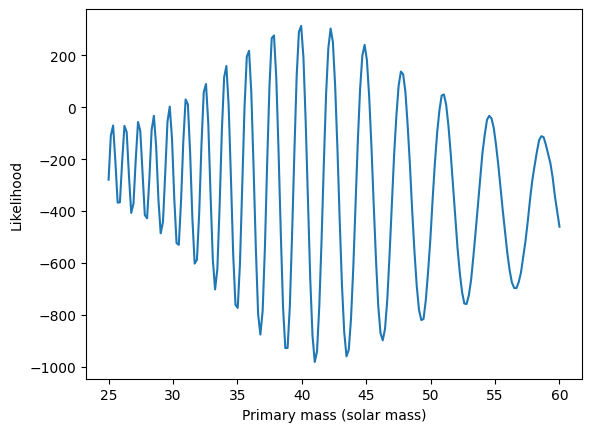

In [30]:
masses=np.linspace(25,60,num=200)
logl_mass=[]

for mass1 in masses:
    param_test = best_guess
    # m1, m2, distance, time, phase, ra, dec, inclination, polarization = param
    param_test[0] = mass1
    logl_mass.append(loglikelihood(param_test))

plt.plot(masses,logl_mass)
plt.ylabel('Likelihood')
plt.xlabel('Primary mass (solar mass)')

**However**, this is just a slice and **not** the marginalised posterior density function for `mass1`. In other to actually compute the marginalised posterior distribution:

$$
p(m_1|s) = \int p(\vec{\lambda}|s)~d (\{\vec{\lambda}\}\setminus \{m_1\})
$$

We need to compute that integral. And one of the most efficient way is to  _sample_ the posterior:

# Posterior sampling

So far we've been generating point estimates for the source parameters, but the whole point of this endeavor was to quantify uncertainties. With our posterior function defined we can now plug into into a Markov chain Monte Carlo sampler in order to draw samples from this probability density function.

With a posterior density function defined, you can now use off-the-shelf samplers, see [Samplers, samplers, everywhere...](http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/) to draw samples from the posterior probability density function.

Several codes are available to do all the above, but as always it's important to know what's inside !

# Reading Posterior Files

The LIGO-Virgo-Kagra GWTC-3 data release on [zenodo](https://zenodo.org/record/5546663#.YmgM7PNBw-Q) contains a notebook to read the posterior samples, do take a look !

#  Challenge

Try the methods we saw on the particularly interesting event GW190521. Check which detectors were online on that [day](https://www.gw-openscience.org/detector_status/). In addition, note that it is _high-mass_ enough for a _sine-Gaussian_, _non-physical_, model, (e.g. `gausspulse()` from `scipy`) to be used.